### Import required packages

In [3]:
import os
import spectrum
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sentsation.connect import get_s3_client, get_s3_resource
from librosa.feature import chroma_stft

### Convert files to .wav  
either get local files or from AWS S3 bucket

In [ ]:
S3_KEY = getenv('AWS_KEY')
S3_SECRET = getenv('AWS_SECRET')
AWS_REGION = getenv('AWS_REGION', 'eu-west-2')
bucket_name = 'cheuky-data-nanodegree'
s3r = get_s3_resource(session_token)
bucket = s3r.Bucket(bucket_name)
s3 = get_s3_client(session_token)

## Feature Extraction  
Ref: https://librosa.github.io/librosa/tutorial.html

In [4]:
filename = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt0.wav'

Loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. The variable sr contains the sampling rate of y, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to librosa.load().  
- Load the audio as a waveform *y* [audio signal]  
- store the sampling rate as *sample_rate* [audio sampling rate of y]  

In [5]:
y, sample_rate = librosa.load(filename)

In [6]:
y

array([-0.01989216, -0.03861826, -0.04231744, ..., -0.00141222,
       -0.00244284,  0.        ], dtype=float32)

In [7]:
print(sample_rate, len(y))

22050 61623


Run the default beat tracker. The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. Since v0.3, librosa uses centered frames, so that the kth frame is centered around sample k * hop_length.

The next operation converts the frame numbers beat_frames into timings

In [8]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sample_rate)

In [9]:
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 172.27 beats per minute


Convert the frame indices of beat events into timestamps

In [10]:
beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)
beat_times

array([0.23219955, 0.58049887])

Compute MFCC features from the raw signal

In [11]:
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, hop_length=512, n_mfcc=13)
mfcc_avg = np.mean(mfcc.T,axis=0) 
mfcc_avg

array([-251.25196689,   98.21981996,   -1.1106248 ,   16.11569341,
         -3.24169344,    1.57295946,   -2.05141186,   -0.80228576,
        -10.40515384,    8.64180519,   -6.61594317,   -0.87151955,
        -11.26616925])

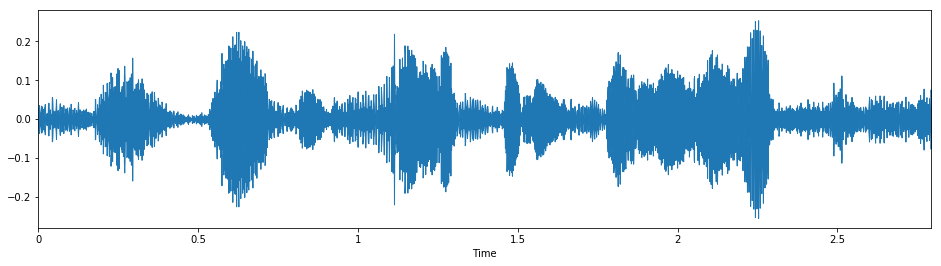

In [12]:
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sample_rate)

### Power / Energy
Apply Short-time Fourier transform (stft)  
- np.abs(D[f, t]) is the magnitude of frequency bin f at frame t  
- np.angle(D[f, t]) is the phase of frequency bin f at frame t

In [13]:
S = np.abs(librosa.stft(y))
# Compute a chromagram from a waveform or power spectrogram
chroma = chroma_stft(S=S, sr=sample_rate)
print('Chroma is a array with shape: ', chroma.shape)
chroma

Chroma is a array with shape:  (12, 121)


array([[0.61504029, 0.67420254, 0.48691435, ..., 0.62187977, 0.60644956,
        0.36870719],
       [0.51329773, 0.54594099, 0.30605157, ..., 0.62285445, 0.73963946,
        0.53345573],
       [0.4401565 , 0.52546343, 0.3140529 , ..., 0.66775178, 0.74023831,
        0.5662866 ],
       ...,
       [0.86173267, 0.83483813, 0.4297478 , ..., 0.90642847, 0.94349356,
        1.        ],
       [0.79816314, 0.89290744, 0.55762898, ..., 1.        , 0.9012611 ,
        0.86062087],
       [0.58786686, 0.66550143, 0.57286288, ..., 0.77597329, 0.75354621,
        0.48421439]])

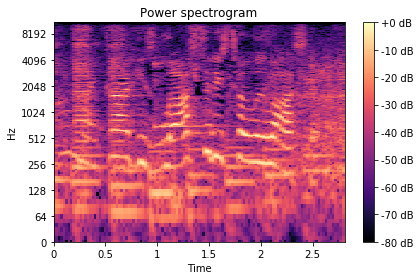

In [14]:
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### Energy  
Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.  
- *S* [spectrogram]  

Example: https://musicinformationretrieval.com/energy.html

In [22]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)

array([[0.79795724, 0.7567896 , 0.72619843, 0.68411934, 0.6960043 ,
        0.9337795 , 1.2604481 , 1.568926  , 1.8391153 , 1.9610084 ,
        1.9632208 , 1.8168192 , 1.5905054 , 1.336826  , 1.026035  ,
        0.8249484 , 0.6446174 , 0.4338118 , 0.29972622, 0.24613391,
        0.61419636, 1.3661587 , 1.9389716 , 2.528267  , 2.8722966 ,
        2.957375  , 2.8429904 , 2.5362031 , 2.1361294 , 1.6652123 ,
        1.282898  , 0.87237334, 1.0976386 , 1.590448  , 1.7910742 ,
        1.7882557 , 1.6170554 , 1.165748  , 0.96557784, 1.1037147 ,
        1.2220942 , 1.2640158 , 1.3240514 , 1.4814358 , 1.8861792 ,
        2.0556116 , 2.4206834 , 2.7972457 , 2.881713  , 3.0250206 ,
        2.8887687 , 2.7034087 , 2.5521448 , 2.229066  , 1.9564257 ,
        1.511253  , 0.967233  , 0.82039756, 0.7383247 , 0.81135046,
        1.7061329 , 2.1062007 , 2.1769319 , 2.247948  , 1.9909953 ,
        1.7759733 , 1.8609447 , 1.7343798 , 1.3389874 , 1.0731988 ,
        0.8109037 , 0.8226605 , 0.8482312 , 1.08

In [21]:
librosa.feature.rms(y=y)

array([[0.01878013, 0.01865894, 0.01764111, 0.016731  , 0.01605467,
        0.01512436, 0.01538494, 0.02064229, 0.02785997, 0.03468367,
        0.04064975, 0.04334567, 0.04340256, 0.04016418, 0.03516269,
        0.02955437, 0.02268211, 0.01823783, 0.01424847, 0.00959014,
        0.00662562, 0.00544144, 0.01357849, 0.03020025, 0.04285754,
        0.05589297, 0.06349363, 0.06537991, 0.06285243, 0.05605812,
        0.04722497, 0.03681263, 0.02833953, 0.0192863 , 0.02426624,
        0.03515529, 0.03959645, 0.03953453, 0.03574079, 0.02576523,
        0.02134653, 0.02439309, 0.0270133 , 0.02791749, 0.02927059,
        0.03275098, 0.0416992 , 0.04544434, 0.05350655, 0.06184102,
        0.06370281, 0.06687663, 0.06386433, 0.05976552, 0.05642249,
        0.04927837, 0.04325208, 0.03340905, 0.0213834 , 0.01813487,
        0.01632254, 0.01793717, 0.03771592, 0.04656202, 0.04812598,
        0.04969641, 0.04401569, 0.03926244, 0.04114106, 0.03834199,
        0.02960208, 0.02372587, 0.01791821, 0.01

### Pitch  
- "pitch_tuning": Given a collection of pitches, estimate its tuning offset (in fractions of a bin) relative to A440=440.0Hz.  
- "piptrack": Pitch tracking on thresholded parabolically-interpolated STFT.  
    - *threshold* - A bin in spectrum X is considered a pitch when it is greater than threshold*X.max()

In [15]:
pitches, magnitudes = librosa.piptrack(y, sample_rate, threshold=0)
# Select out pitches with high energy
# pitches = pitches[magnitudes > np.median(magnitudes)]
librosa.pitch_tuning(pitches)

-0.15999999999999998

## Join features with labels in metadata

## Building Models

In [ ]:
from sklearn.preprocessing import LabelEncoder
feature = mfccs
label = row.Class
X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

In [ ]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('CNN accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper_left')
plt.show()